### ปฏิบัติการครั้งที่ 8

ดาวน์โหลดข้อมูลอุณหภูมิสูงสุดรายวันปี 1998-2019 จาก link ข้างล่างนี้  
https://donlapark.pages.dev/229351/data/CM_temp.csv

1. เปลี่ยนจากข้อมูลรายวันให้เป็นข้อมูลค่าเฉลี่ยรายเดือน
2. จงแบ่งข้อมูลโดยให้ Test set เป็นข้อมูลของ 24 เดือนสุดท้ายและ Training set เป็นข้อมูลก่อนหน้าทั้งหมด
3. ลองสร้างโมเดล Holt-Winters แบบต่างๆ (damped, non-damped, additive, multiplicative etc.) แล้วระบุโมเดลที่ดีที่ให้ค่า RMSE บน test set น้อยที่สุด
4. จงแสดงแผนภาพของข้อมูลจริงกับข้อมูลที่ได้ในข้อ 3

In [1]:
!wget -O CM_temp.csv https://donlapark.pages.dev/229351/data/CM_temp.csv

--2025-09-17 13:08:28--  https://donlapark.pages.dev/229351/data/CM_temp.csv
Resolving donlapark.pages.dev (donlapark.pages.dev)... 172.66.44.200, 172.66.47.56, 2606:4700:310c::ac42:2f38, ...
Connecting to donlapark.pages.dev (donlapark.pages.dev)|172.66.44.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139473 (136K) [text/csv]
Saving to: ‘CM_temp.csv’

CM_temp.csv         100%[===================>] 136.20K  --.-KB/s    in 0.03s   

2025-09-17 13:08:28 (3.94 MB/s) - ‘CM_temp.csv’ saved [139473/139473]



In [2]:
# import module ที่ต้องใช้
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from datetime import datetime

In [3]:
# ฟังก์ชันที่เปลี่ยน string ให้เป็น datetime
def parser(dates):
  return datetime.strptime(dates, '%Y-%m-%d')

# parse_dates ชื่อของคอลัมน์ที่จะเปลี่ยนให้เป็น datetime
# index_col ชื่อของคอลัมน์ที่จะให้เป็น index
# date_parser ฟังก์ชันที่เปลี่ยน string ให้เป็น datetime
data = pd.read_csv('CM_temp.csv', parse_dates=['Date'],
                                        index_col='Date',
                                        date_parser=parser)

data.tail()

/tmp/ipython-input-2705365328.py:8: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pd.read_csv('CM_temp.csv', parse_dates=['Date'],


,MaxTemp
Date,
2019-07-27,26.2
2019-07-28,34.2
2019-07-29,34.4
2019-07-30,33.5
2019-07-31,30.7


ข้อมูลที่ได้เป็นข้อมูลรายวัน ทำการหาค่าเฉลี่ยรายเดือนด้วย method `resample`

In [4]:
data_monthly = data['MaxTemp'].resample("M").mean()

data_monthly.head()

/tmp/ipython-input-3219926365.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_monthly = data['MaxTemp'].resample("M").mean()


,MaxTemp
Date,
1998-01-31,31.687097
1998-02-28,33.685714
1998-03-31,37.103226
1998-04-30,37.910000
1998-05-31,35.848387


In [5]:
def rmse(y_true,y_pred):
  # Inputs
  # y_true: actual value, y_pred: predicted values
  # Output: RMSE between y_true and y_pred
  return np.sqrt(np.mean(np.square(y_true-y_pred)))

In [9]:
# แบ่งข้อมูลโดยให้ Test set เป็นข้อมูลของ 24 เดือนสุดท้ายและ Training set เป็นข้อมูลก่อนหน้าทั้งหมด
train_size = len(data_monthly) - 24
train_data, test_data = data_monthly[0:train_size], data_monthly[train_size:]

In [10]:
# สร้างโมเดล Holt-Winters แบบต่างๆ
models = {
    'additive': ExponentialSmoothing(train_data, seasonal='add', seasonal_periods=12).fit(),
    'multiplicative': ExponentialSmoothing(train_data, seasonal='mul', seasonal_periods=12).fit(),
    'additive_damped': ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=12, damped_trend=True).fit(),
    'multiplicative_damped': ExponentialSmoothing(train_data, trend='mul', seasonal='mul', seasonal_periods=12, damped_trend=True).fit()
}

In [11]:
# ระบุโมเดลที่ดีที่ให้ค่า RMSE บน test set น้อยที่สุด
best_model_name = None
best_rmse = float('inf')
results = {}

for name, model in models.items():
  predictions = model.predict(start=len(train_data), end=len(data_monthly)-1)
  current_rmse = rmse(test_data, predictions)
  results[name] = current_rmse
  print(f'{name} RMSE: {current_rmse}')

  if current_rmse < best_rmse:
    best_rmse = current_rmse
    best_model_name = name

print(f'\nBest model: {best_model_name} with RMSE: {best_rmse}')

additive RMSE: 1.124286066564405
multiplicative RMSE: 1.12003424586557
additive_damped RMSE: 1.1134955121933203
multiplicative_damped RMSE: 1.10643357265325

Best model: multiplicative_damped with RMSE: 1.10643357265325


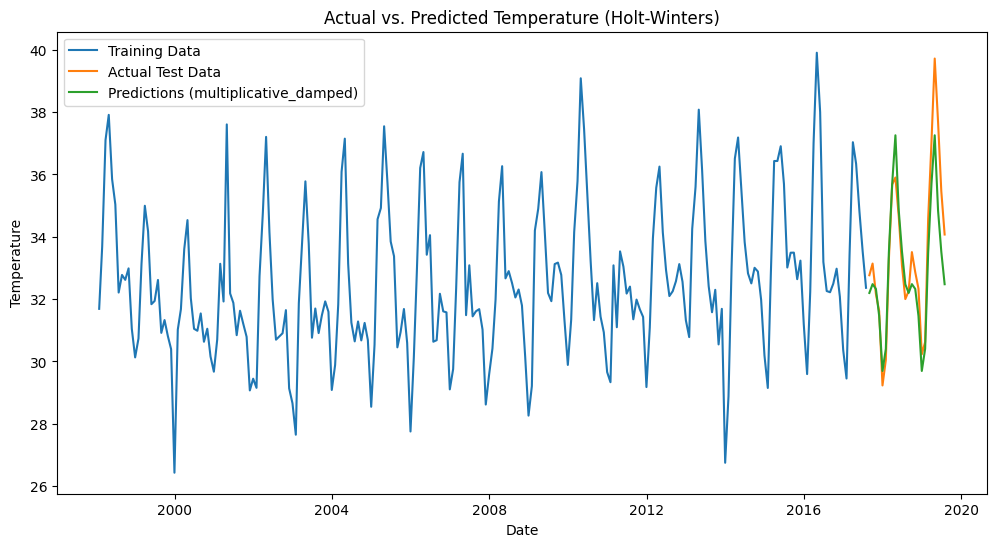

In [13]:
# แสดงแผนภาพของข้อมูลจริงกับข้อมูลที่ได้
best_model = models[best_model_name]
test_predictions = best_model.predict(start=len(train_data), end=len(data_monthly)-1)

plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Actual Test Data')
plt.plot(test_predictions.index, test_predictions, label=f'Predictions ({best_model_name})')
plt.title('Actual vs. Predicted Temperature (Holt-Winters)')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()